
# ML Zoomcamp — Homework 03 (Lead Scoring)

This notebook solves Q1–Q6 for the **Bank Marketing / Lead Scoring** dataset.

Dataset: `course_lead_scoring.csv`  
Target: **`converted`** (has the client signed up or not)

**What we do:**  
- Load and inspect data  
- Required imputations (categorical → `'NA'`, numerical → `0.0`)  
- Q1: Mode of `industry`  
- Q2: Correlation (between specific pairs)  
- Train/Val/Test split (60/20/20)  
- Q3: Mutual information (categoricals vs target)  
- Q4: Logistic Regression (with One-Hot) + validation accuracy  
- Q5: Simple feature elimination by dropping one feature at a time  
- Q6: Regularized Logistic Regression sweep on `C`


## Setup

In [1]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
RANDOM_STATE = 42


## 1. Load data

In [2]:

url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)
print(df.shape)
df.head()


(1462, 9)


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1



## 2. Data preparation

- Fill **categorical** NAs with `'NA'`  
- Fill **numeric** NAs with `0.0`  
- Keep `converted` unchanged as target


In [3]:

target_col = "converted"

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c != target_col]

df_clean = df.copy()
for c in cat_cols:
    df_clean[c] = df_clean[c].fillna("NA")
for c in num_cols:
    df_clean[c] = df_clean[c].fillna(0.0)

df_clean.isna().sum()


lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

## Q1. Mode of `industry`

In [4]:

industry_mode = df_clean["industry"].mode(dropna=False)[0]
industry_mode


'retail'


## Q2. Correlation among selected pairs

We compute Pearson correlations for the following pairs only:
- (`interaction_count`, `lead_score`)
- (`number_of_courses_viewed`, `lead_score`)
- (`number_of_courses_viewed`, `interaction_count`)
- (`annual_income`, `interaction_count`)


In [5]:

pairs = [
    ("interaction_count", "lead_score"),
    ("number_of_courses_viewed", "lead_score"),
    ("number_of_courses_viewed", "interaction_count"),
    ("annual_income", "interaction_count"),
]

corrs = {}
for a, b in pairs:
    corrs[(a, b)] = df_clean[[a, b]].corr().iloc[0,1]

corrs


{('interaction_count', 'lead_score'): np.float64(0.009888182496913131),
 ('number_of_courses_viewed', 'lead_score'): np.float64(-0.004878998354681276),
 ('number_of_courses_viewed',
  'interaction_count'): np.float64(-0.023565222882888037),
 ('annual_income', 'interaction_count'): np.float64(0.02703647240481443)}

### (Optional) Quick numeric correlation heatmap

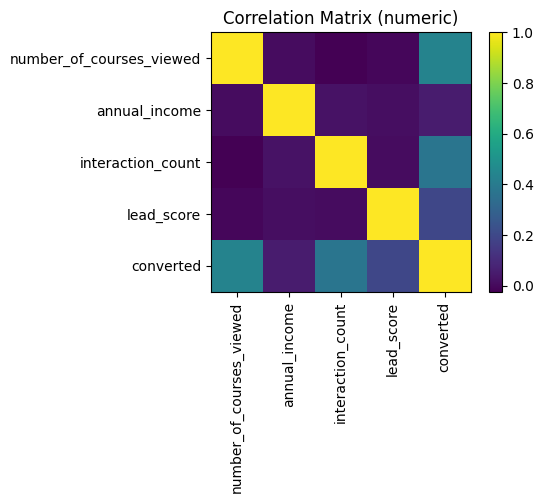

In [6]:

num_df = df_clean.select_dtypes(include=[np.number])
corr_mat = num_df.corr()

plt.figure(figsize=(6,5))
plt.imshow(corr_mat, interpolation='nearest')
plt.title("Correlation Matrix (numeric)")
plt.xticks(range(len(num_df.columns)), num_df.columns, rotation=90)
plt.yticks(range(len(num_df.columns)), num_df.columns)
plt.colorbar()
plt.tight_layout()
plt.show()


## 3. Train / Validation / Test split (60/20/20)

In [7]:

# Features/target
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col].values

# 20% test, then 25% of the remaining 80% -> 20% validation, 60% train
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)


(876, 293, 293)

## Q3. Mutual Information (categoricals vs target, train only)

In [8]:

def mi_cat(x, y):
    return mutual_info_score(x, y)

cats_for_q3 = ["industry", "location", "lead_source", "employment_status"]
mi_scores = {}
for c in cats_for_q3:
    mi = mi_cat(X_train[c], y_train)
    mi_scores[c] = round(mi, 2)

mi_scores


{'industry': 0.01,
 'location': 0.0,
 'lead_source': 0.03,
 'employment_status': 0.01}


## Q4. Logistic Regression (with One-Hot Encoding)

- `solver='liblinear'`, `C=1.0`, `max_iter=1000`, `random_state=42`
- Evaluate accuracy on validation set (rounded to 2 decimals)


In [9]:

all_cat = X_train.select_dtypes(include=["object"]).columns.tolist()
all_num = X_train.select_dtypes(include=[np.number]).columns.tolist()

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), all_cat),
        ("num", "passthrough", all_num),
    ],
    remainder="drop",
)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=RANDOM_STATE)

pipe = Pipeline([
    ("pre", pre),
    ("lr", model),
])

pipe.fit(X_train, y_train)
val_pred = pipe.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
val_acc, round(val_acc, 2)


(0.7303754266211604, 0.73)


## Q5. Feature Elimination (drop-one) 

Drop each of the following **one at a time** and measure change in validation accuracy:

- `'industry'`
- `'employment_status'`
- `'lead_score'`

Report the difference: **(base accuracy - accuracy without feature)**.


In [10]:

base_acc = val_acc
to_test_drop = ["industry", "employment_status", "lead_score"]
diffs = {}

for feat in to_test_drop:
    X_train_drop = X_train.drop(columns=[feat])
    X_val_drop = X_val.drop(columns=[feat])

    all_cat_drop = X_train_drop.select_dtypes(include=["object"]).columns.tolist()
    all_num_drop = X_train_drop.select_dtypes(include=[np.number]).columns.tolist()

    pre_drop = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), all_cat_drop),
            ("num", "passthrough", all_num_drop),
        ],
        remainder="drop",
    )

    pipe_drop = Pipeline([
        ("pre", pre_drop),
        ("lr", LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=RANDOM_STATE)),
    ])

    pipe_drop.fit(X_train_drop, y_train)
    val_pred_drop = pipe_drop.predict(X_val_drop)
    acc_drop = accuracy_score(y_val, val_pred_drop)
    diffs[feat] = base_acc - acc_drop

diffs


{'industry': 0.0,
 'employment_status': -0.0034129692832765013,
 'lead_score': 0.0}

In [11]:
# === Q5: Feature Elimination (one-cell version) ===

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Base accuracy from full model (trained as in Q4)
all_cat = X_train.select_dtypes(include=["object"]).columns.tolist()
all_num = X_train.select_dtypes(include=["number"]).columns.tolist()

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), all_cat),
        ("num", "passthrough", all_num),
    ],
    remainder="drop",
)

base_model = Pipeline([
    ("pre", pre),
    ("lr", LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=RANDOM_STATE)),
])

base_model.fit(X_train, y_train)
val_pred = base_model.predict(X_val)
base_acc = accuracy_score(y_val, val_pred)

# Now drop each feature and measure difference
to_test_drop = ["industry", "employment_status", "lead_score"]
diffs = {}

for feat in to_test_drop:
    X_train_drop = X_train.drop(columns=[feat])
    X_val_drop = X_val.drop(columns=[feat])

    all_cat_drop = X_train_drop.select_dtypes(include=["object"]).columns.tolist()
    all_num_drop = X_train_drop.select_dtypes(include=["number"]).columns.tolist()

    pre_drop = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), all_cat_drop),
            ("num", "passthrough", all_num_drop),
        ],
        remainder="drop",
    )

    pipe_drop = Pipeline([
        ("pre", pre_drop),
        ("lr", LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=RANDOM_STATE)),
    ])

    pipe_drop.fit(X_train_drop, y_train)
    acc_drop = accuracy_score(y_val, pipe_drop.predict(X_val_drop))
    diffs[feat] = base_acc - acc_drop

# Print results
print(f"Base accuracy: {base_acc:.5f}")
for feat, diff in diffs.items():
    print(f"Drop {feat:<20} => diff = {diff:+.6f}")

least_useful = min(diffs, key=lambda k: abs(diffs[k]))
print(f"\nLeast useful feature (smallest impact): '{least_useful}'")

Base accuracy: 0.73038
Drop industry             => diff = +0.000000
Drop employment_status    => diff = -0.003413
Drop lead_score           => diff = +0.000000

Least useful feature (smallest impact): 'industry'



## Q6. Regularized Logistic Regression — sweep over C

Test `C = [0.01, 0.1, 1, 10, 100]` and report validation accuracy (rounded to 3 decimals).  
Pick the **smallest** `C` in case of ties.


In [12]:

Cs = [0.01, 0.1, 1, 10, 100]
acc_by_C = {}
for C in Cs:
    pipeC = Pipeline([
        ("pre", pre),
        ("lr", LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=RANDOM_STATE)),
    ])
    pipeC.fit(X_train, y_train)
    predC = pipeC.predict(X_val)
    acc_by_C[C] = round(accuracy_score(y_val, predC), 3)

best_acc = max(acc_by_C.values())
best_C = sorted([C for C,a in acc_by_C.items() if a == best_acc])[0]
acc_by_C, best_C


({0.01: 0.734, 0.1: 0.73, 1: 0.73, 10: 0.73, 100: 0.73}, 0.01)